In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', 'abf5cdc2d8fe408b8a4a1bac5dbcde95')

In [4]:
results = search_images_bing(key, '1993 mazda rx7 fd')
ims = results.attrgot('contentUrl')
len(ims)

150

In [6]:
car_types = '1997 acura nsx', '1994 toyota supra mk4', '1993 mazda rx7 fd', '1999 nissan gtr r34'
path = Path('cars')

In [7]:
if not path.exists():
    path.mkdir()
    for o in car_types:
        dest=(path/o)
        dest.mkdir(exist_ok=True)
        results=search_images_bing(key,o)
        download_images(dest, urls=results.attrgot('contentUrl'))

In [8]:
fns = get_image_files(path)
fns

(#459) [Path('cars/1993 mazda rx7 fd/001be444-a18d-4bdc-93be-003d91d9e05f.jpg'),Path('cars/1993 mazda rx7 fd/001e0377-37fe-4b8e-b985-c0191653ca40.jpeg'),Path('cars/1993 mazda rx7 fd/0331e217-5465-411d-aa57-d8bb53381558.jpg'),Path('cars/1993 mazda rx7 fd/0794f7f0-94e9-4864-ae65-0fb00102397d.jpg'),Path('cars/1993 mazda rx7 fd/08362008-2a8b-48bf-86a8-00de66ca13c1.jpg'),Path('cars/1993 mazda rx7 fd/08770757-ac69-4a44-bee0-a45612b6a4ed.jpg'),Path('cars/1993 mazda rx7 fd/08830a21-d816-4965-98f8-ae91a4b355b4.jpg'),Path('cars/1993 mazda rx7 fd/0986e799-483d-436b-aa32-6a6a8a01f89c.jpg'),Path('cars/1993 mazda rx7 fd/0a51fbee-2e84-4401-b2d3-48332eae939f.jpg'),Path('cars/1993 mazda rx7 fd/0a9cc4a9-3622-43ae-9d70-e6603ba199d9.jpg')...]

In [9]:
failed = verify_images(fns)
failed

(#0) []

In [10]:
failed.map(Path.unlink)

(#0) []

In [11]:
cars = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [12]:
dls = cars.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


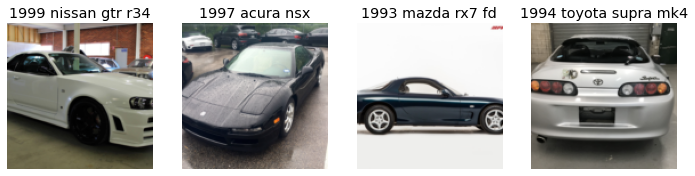

In [13]:
dls.valid.show_batch(max_n=4, nrows=1)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


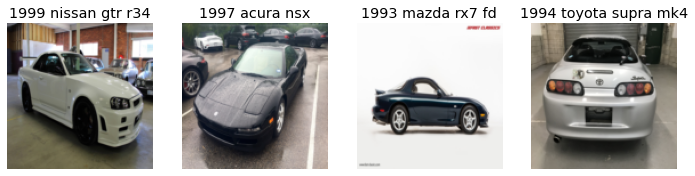

In [14]:
# example of the squish method
cars = cars.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = cars.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [15]:
# using randomresizecrop for the actual resize method
cars = cars.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = cars.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [16]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(8)

C:\Users\oneillk2\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\oneillk2\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,2.310687,2.430887,0.593407,00:48


epoch,train_loss,valid_loss,error_rate,time
0,1.376904,1.396280,0.527473,00:57
1,1.258567,1.066692,0.373626,00:57
2,1.101780,0.951430,0.274725,00:56
3,0.971615,0.781385,0.230769,00:57
4,0.815893,0.657665,0.197802,00:57
5,0.712085,0.616255,0.197802,00:59
6,0.639749,0.609251,0.197802,00:58
7,0.577808,0.590831,0.197802,00:56


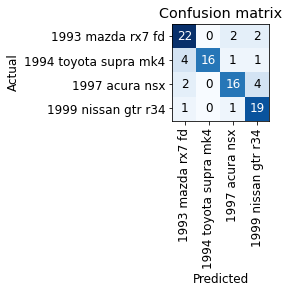

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

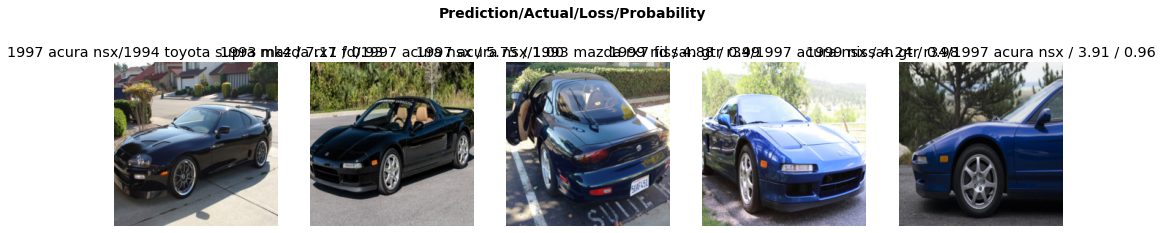

In [22]:
interp.plot_top_losses(5, nrows=1, figsize=(17,4))

In [23]:
from fastai.vision.widgets import * 
cleaner = ImageClassifierCleaner(learn)
cleaner

i dont actually need to clean or delete any of these pictures as they are all pretty good.

The idea is before you start data cleaning always build a model to tell what things the model will have a 
hard time differentiaing

In [24]:
learn.export()

In [25]:
path = Path()

In [26]:
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [27]:
learn_inf= load_learner(path/'export.pkl')

In [28]:
learn_inf.predict('images/rx7.jpg')

('1993 mazda rx7 fd',
 TensorBase(0),
 TensorBase([0.9505, 0.0210, 0.0090, 0.0195]))

In [29]:
learn_inf.dls.vocab

['1993 mazda rx7 fd', '1994 toyota supra mk4', '1997 acura nsx', '1999 nissan gtr r34']

In [31]:
btn_upload = widgets.FileUpload()

In [32]:
btn_upload

FileUpload(value={}, description='Upload')

In [34]:
btn_upload = SimpleNamespace(data = ['images/rx7.jpg'])

In [36]:
img = PILImage.create(btn_upload.data[-1])

In [37]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [40]:
pred, pred_idx, probs = learn_inf.predict(img)

In [42]:
lbl_pred=widgets.Label()
lbl_pred.value=f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: 1993 mazda rx7 fd; Probability: 0.9505')

In [44]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [45]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value=f'Prediction: {pred}; Probability{probs[pred_idx]:.04f}'

In [46]:
btn_run.on_click(on_click_classify)

In [47]:
btn_upload = widgets.FileUpload()

In [48]:
VBox([widgets.Label('Select your car!'),
     btn_upload, btn_run, out_pl, lbl_pred])

In [3]:
# !pip install voila
!jupyter serverextension enable --sys-prefix voila 

Enabling: voila
- Writing config: C:\Users\oneillk2\Anaconda3\envs\pythonProject4\etc\jupyter
    - Validating...
      voila 0.3.6 ok
